In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/aisys24

/content/drive/MyDrive/aisys24


In [4]:
!ls

0603results  0604results  CNN_final.ipynb  CNN.ipynb  data


### CNN + MNIST & CIFAR-10

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import f1_score
import pandas as pd

In [6]:
# Random seed 고정
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [7]:
# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]) # MNIST, (1, 28, 28)

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) # CIFAR-10, (3, 32, 32)

# MNIST
train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Train/Validation split
train_size = int(0.8 * len(train_dataset_mnist))
validation_size = len(train_dataset_mnist) - train_size
train_dataset_mnist, val_dataset_mnist = random_split(train_dataset_mnist, [train_size, validation_size])

train_loader_mnist = DataLoader(dataset=train_dataset_mnist, batch_size=64, shuffle=True)
val_loader_mnist = DataLoader(dataset=val_dataset_mnist, batch_size=64, shuffle=False)
test_loader_mnist = DataLoader(dataset=test_dataset_mnist, batch_size=64, shuffle=False)

# CIFAR-10
train_dataset_cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
test_dataset_cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

# Train/Validation split
train_size = int(0.8 * len(train_dataset_cifar10))
validation_size = len(train_dataset_cifar10) - train_size
train_dataset_cifar10, val_dataset_cifar10 = random_split(train_dataset_cifar10, [train_size, validation_size])

train_loader_cifar10 = DataLoader(dataset=train_dataset_cifar10, batch_size=64, shuffle=True)
val_loader_cifar10 = DataLoader(dataset=val_dataset_cifar10, batch_size=64, shuffle=False)
test_loader_cifar10 = DataLoader(dataset=test_dataset_cifar10, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class CNN(nn.Module):
    def __init__(self, activation_function):
        super(CNN, self).__init__()
        if dataset_name == 'MNIST':
          input_channels = 1
          fc1_input_size = 16 * 4 * 4
        else:
          input_channels = 3
          fc1_input_size = 16 * 5 * 5
        self.conv1 = nn.Conv2d(input_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(fc1_input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.activation_function = activation_function

    def forward(self, x):
        x = self.pool(self.activation_function(self.conv1(x)))
        x = self.pool(self.activation_function(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
dataset_name = 'MNIST'
cnn_model = CNN(F.relu)
for name, p in cnn_model.named_parameters():
	print(name)

conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias


In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [11]:
def train_and_evaluate_model(activation_function, train_loader, val_loader, test_loader, epochs=50, patience=5):
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN(activation_function).to(device)
    model.apply(init_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    f1_scores = []
    epoch_times = []
    gradients = {name: [] for name, param in model.named_parameters() if param.requires_grad and 'weight' in name}
    # requires_grad==True이면 Gradient 계산 대상, bias 제외한 weight만 모으기 위해 조건 추가

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        start_time = time.time() # epoch마다 학습 시간 (시작)
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        ############################################################
        # Collect gradients at the end of the epoch
        for name, param in model.named_parameters():
            if param.requires_grad and 'weight' in name:
                gradients[name].append(torch.norm(param.grad, p=2).item())
        ############################################################

        train_loss_history.append(train_loss / len(train_loader))
        train_acc_history.append(100. * correct / total)
        epoch_time = time.time() - start_time # 학습 시간 (종료)
        epoch_times.append(epoch_time)

        # Evaluation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_targets = []
        all_predictions = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(100. * correct / total)
        f1_scores.append(f1_score(all_targets, all_predictions, average='macro'))

        print(f'Epoch: {epoch+1}, Train Loss: {train_loss_history[-1]:.3f}, Val Loss: {val_loss_history[-1]:.3f}, Train Acc: {train_acc_history[-1]:.2f}%, Val Acc: {val_acc_history[-1]:.2f}%, F1 Score: {f1_scores[-1]:.3f}, Time: {epoch_time:.2f}s')

        # Early stopping check
        if val_loss_history[-1] < best_val_loss:
            best_val_loss = val_loss_history[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Final evaluation on test set
    test_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    test_f1 = f1_score(all_targets, all_predictions, average='macro')

    print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%, Test F1 Score: {test_f1:.3f}')


    results_df = pd.DataFrame({
        'epoch': list(range(1, len(train_loss_history) + 1)),
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history,
        'f1_scores': f1_scores,
        'epoch_times': epoch_times,
    })

    gradients_df = pd.DataFrame(gradients)

    return results_df, gradients_df, {
        'test_loss': test_loss,
        'test_acc': test_acc,
        'test_f1': test_f1
    }

In [14]:
dataset_name = 'MNIST'
cnn_model_mnist = CNN(F.relu)
print(cnn_model_mnist)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
dataset_name = 'CIFAR-10'
cnn_model_cifar10 = CNN(F.relu)
print(cnn_model_cifar10)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
activation_functions = {
    'sigmoid': torch.sigmoid,
    'ReLU': F.relu,
    'LReLU': F.leaky_relu,
    'ELU': F.elu,
    'SeLU': F.selu
}

results_mnist = {}
results_cifar10 = {}

for name, activation in activation_functions.items():
    print(f'Running experiment with {name} activation on MNIST')
    dataset_name = 'MNIST'
    results_mnist[name] = train_and_evaluate_model(activation, train_loader_mnist, val_loader_mnist, test_loader_mnist)

    print(f'Running experiment with {name} activation on CIFAR-10')
    dataset_name = 'CIFAR-10'
    results_cifar10[name] = train_and_evaluate_model(activation, train_loader_cifar10, val_loader_cifar10, test_loader_cifar10)

Running experiment with sigmoid activation on MNIST
Epoch: 1, Train Loss: 0.918, Val Loss: 0.269, Train Acc: 72.51%, Val Acc: 92.67%, F1 Score: 0.926, Time: 14.40s
Epoch: 2, Train Loss: 0.182, Val Loss: 0.147, Train Acc: 94.90%, Val Acc: 95.67%, F1 Score: 0.957, Time: 12.89s
Epoch: 3, Train Loss: 0.115, Val Loss: 0.101, Train Acc: 96.63%, Val Acc: 96.97%, F1 Score: 0.970, Time: 12.83s
Epoch: 4, Train Loss: 0.087, Val Loss: 0.081, Train Acc: 97.35%, Val Acc: 97.51%, F1 Score: 0.975, Time: 12.58s
Epoch: 5, Train Loss: 0.072, Val Loss: 0.072, Train Acc: 97.78%, Val Acc: 97.90%, F1 Score: 0.979, Time: 12.85s
Epoch: 6, Train Loss: 0.062, Val Loss: 0.068, Train Acc: 98.07%, Val Acc: 98.03%, F1 Score: 0.980, Time: 12.85s
Epoch: 7, Train Loss: 0.055, Val Loss: 0.062, Train Acc: 98.24%, Val Acc: 98.19%, F1 Score: 0.982, Time: 13.41s
Epoch: 8, Train Loss: 0.050, Val Loss: 0.061, Train Acc: 98.44%, Val Acc: 98.14%, F1 Score: 0.981, Time: 12.99s
Epoch: 9, Train Loss: 0.044, Val Loss: 0.062, Train 

### Dataframe 저장

In [16]:
for name, result in results_mnist.items():
  results_df = result[0]
  gradients_df = result[1]
  results_df.to_csv(f'{name}-result-mnist.csv')
  gradients_df.to_csv(f'{name}-grad-mnist.csv')

In [17]:
for name, result in results_cifar10.items():
  results_df = result[0]
  gradients_df = result[1]
  results_df.to_csv(f'{name}-result-cifar10.csv')
  gradients_df.to_csv(f'{name}-grad-cifar10.csv')

In [18]:
# Test 결과 저장
def save_test_results_to_dataframe(results, filename):
    data = {
        'Activation Function': [],
        'Test Accuracy': [],
        'Test Loss': [],
        'Test F1 Score': []
    }

    for activation_name, result in results.items():
        data['Activation Function'].append(activation_name)
        data['Test Accuracy'].append(result[2]['test_acc'])
        data['Test Loss'].append(result[2]['test_loss'])
        data['Test F1 Score'].append(result[2]['test_f1'])

    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

save_test_results_to_dataframe(results_mnist, 'test-mnist.csv')
save_test_results_to_dataframe(results_cifar10, 'test-cifar10.csv')

### Loss, Acc, F1-score 시각화 (그래프)

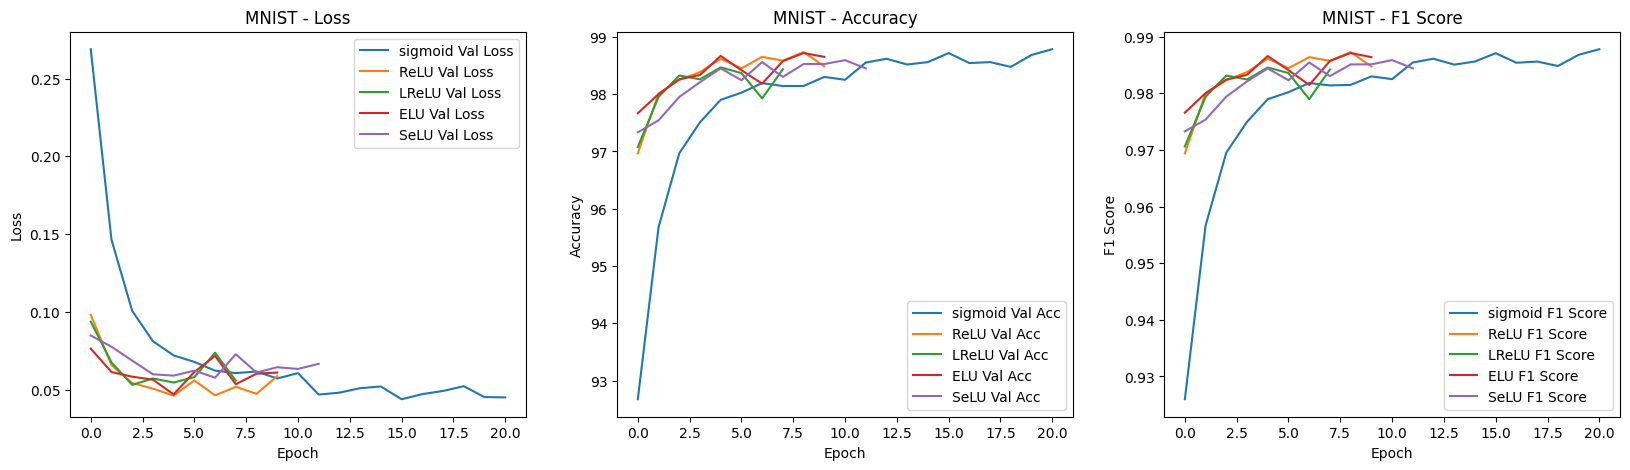

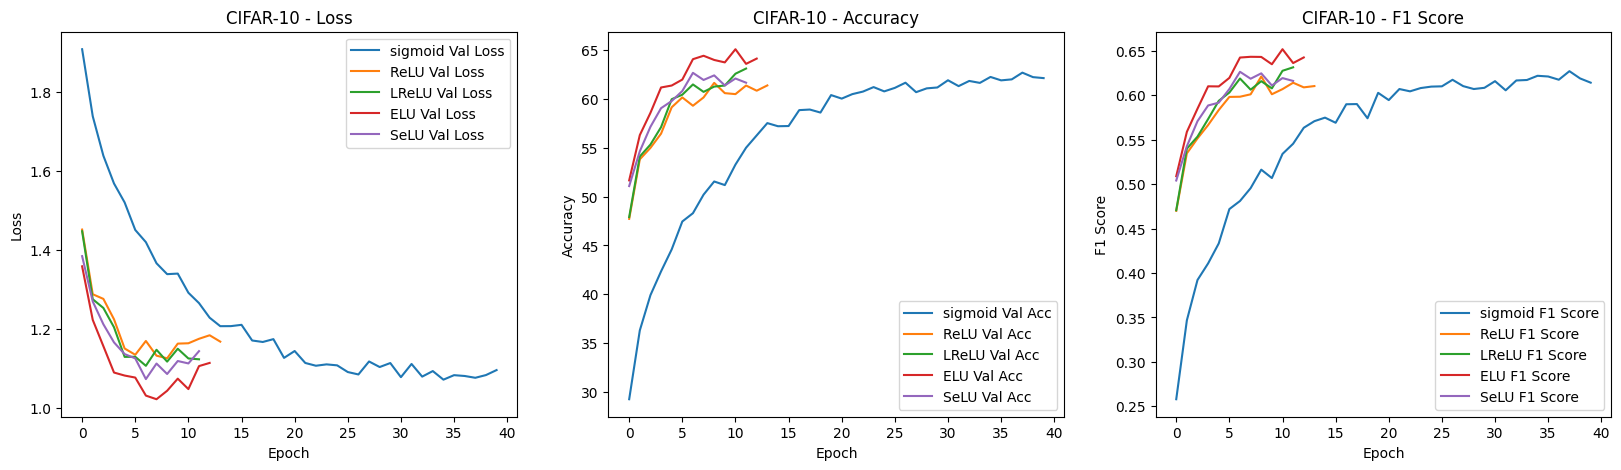

In [19]:
# loss, acc, f1 score
def plot_results_1(results, title):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    for name, result in results.items():
        plt.plot(result[0]['val_loss'], label=f'{name} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    for name, result in results.items():
        plt.plot(result[0]['val_acc'], label=f'{name} Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    for name, result in results.items():
        plt.plot(result[0]['f1_scores'], label=f'{name} F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title(f'{title} - F1 Score')
    plt.legend()

    plt.show()

plot_results_1(results_mnist, 'MNIST')
plot_results_1(results_cifar10, 'CIFAR-10')

### Gradient 시각화
  - 층마다 평균 가중치 시각화

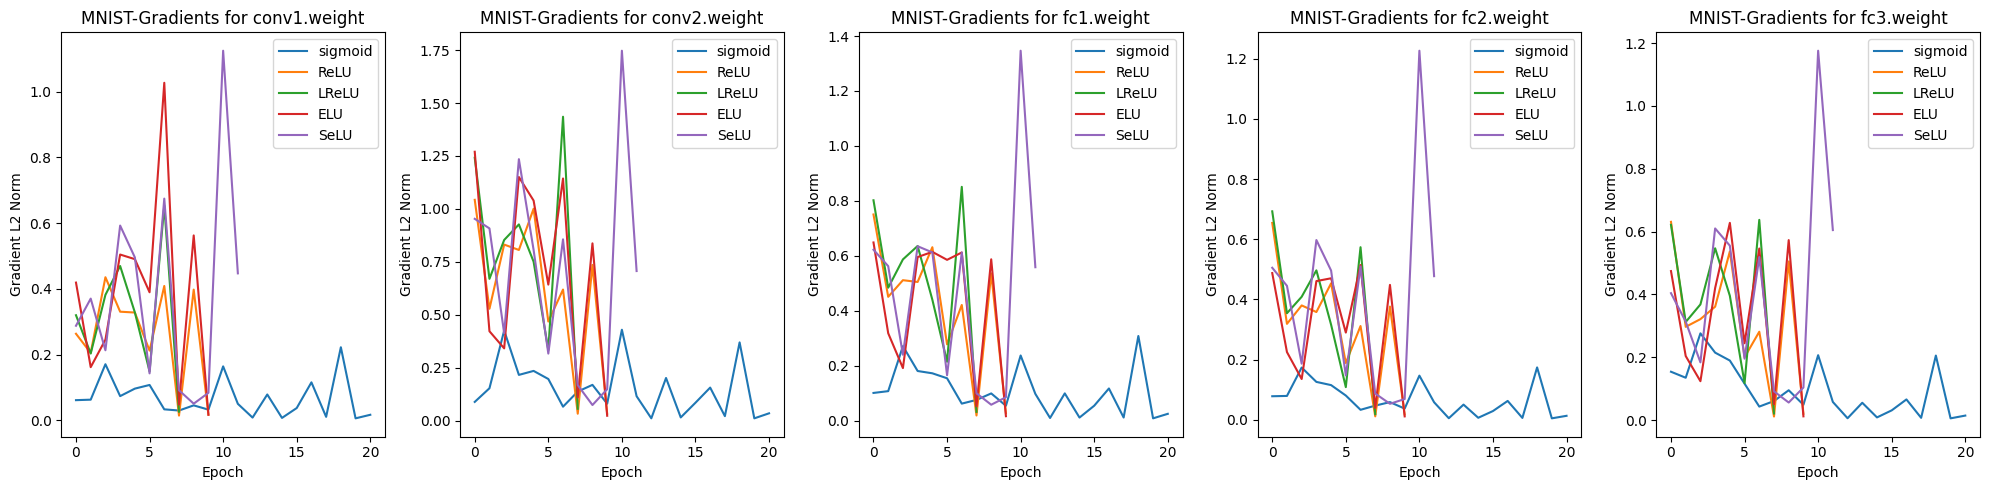

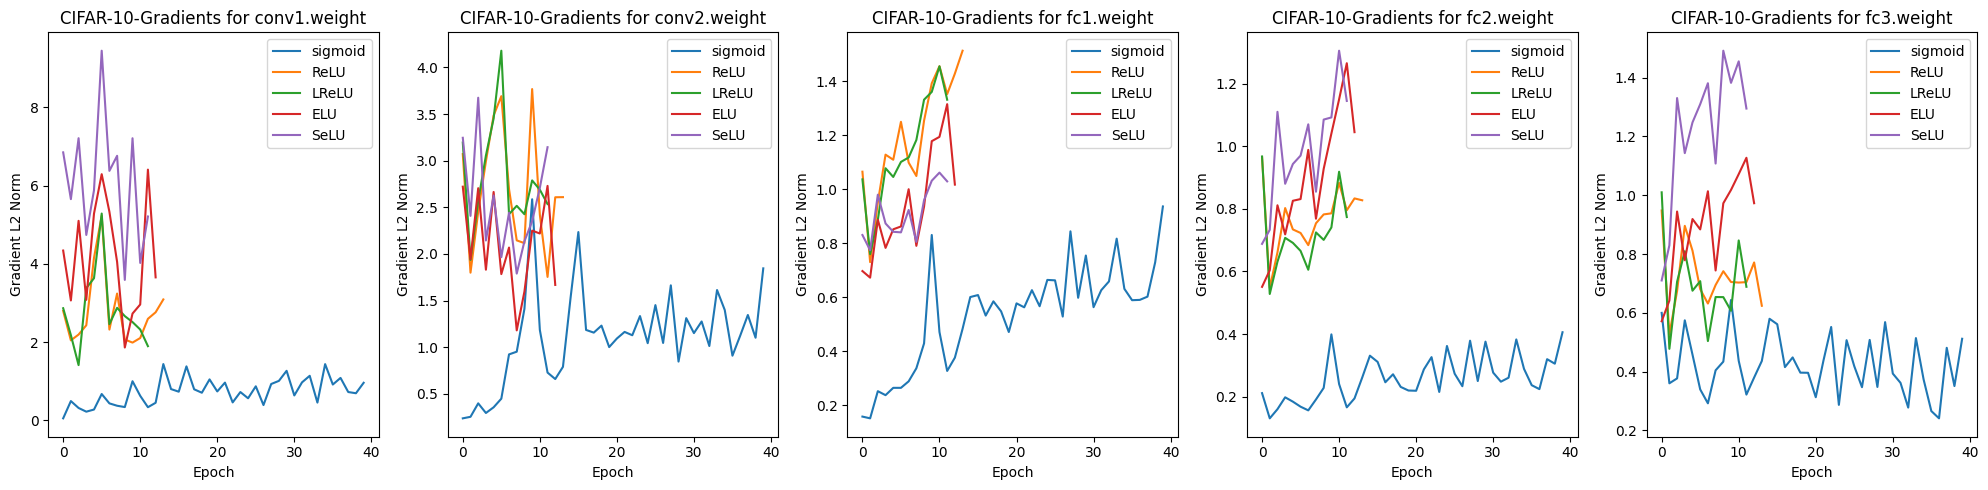

In [20]:
def plot_gradients(results, title):
    # 레이어와 활성화 함수 이름
    layers = ['conv1.weight', 'conv2.weight', 'fc1.weight', 'fc2.weight', 'fc3.weight']
    activation_functions = list(results.keys())

    # 시각화
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))

    for i, layer in enumerate(layers):
        for activation in activation_functions:
            axs[i].plot(results[activation][1][layer], label=activation)
        axs[i].set_title(f'{title}-Gradients for {layer}')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Gradient L2 Norm')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

plot_gradients(results_mnist, 'MNIST')
plot_gradients(results_cifar10, 'CIFAR-10')

### 학습 시간
  - 전체 시간, Epoch 평균

In [21]:
def pd_time(results):
    results_list = {'sigmoid': [],
                    'ReLU': [],
                    'LReLU': [],
                    'ELU': [],
                    'SeLU': []}
    for name, result in results.items():
        epoch = len(result[0]['epoch_times'])
        all = sum(result[0]['epoch_times'])
        avg = all / epoch
        results_list[name] = [all, avg]

    return pd.DataFrame(results_list, index = ['전체 시간', '평균 시간'])

In [22]:
time_mnist = pd_time(results_mnist)
time_mnist.to_csv('time-mnist.csv')
time_cifar10 = pd_time(results_cifar10)
time_cifar10.to_csv('time-cifar10.csv')
print("MNIST Training Times:")
print(time_mnist)
print("\nCIFAR-10 Training Times:")
print(time_cifar10)

MNIST Training Times:
          sigmoid        ReLU       LReLU         ELU        SeLU
전체 시간  272.170713  126.832334  101.476913  127.258621  151.900017
평균 시간   12.960510   12.683233   12.684614   12.725862   12.658335

CIFAR-10 Training Times:
          sigmoid        ReLU       LReLU         ELU        SeLU
전체 시간  495.139116  174.472198  148.792898  158.958593  151.251867
평균 시간   12.378478   12.462300   12.399408   12.227584   12.604322


### Test 결과

In [23]:
mnist_test_results_df = pd.read_csv('test-mnist.csv')
cifar10_test_results_df = pd.read_csv('test-cifar10.csv')

print("MNIST Test Results:")
print(mnist_test_results_df)

print("\nCIFAR-10 Test Results:")
print(cifar10_test_results_df)

MNIST Test Results:
  Activation Function  Test Accuracy  Test Loss  Test F1 Score
0             sigmoid          98.84   0.037733       0.988250
1                ReLU          98.49   0.051617       0.984720
2               LReLU          98.50   0.051404       0.984942
3                 ELU          98.54   0.058473       0.985235
4                SeLU          98.74   0.055374       0.987368

CIFAR-10 Test Results:
  Activation Function  Test Accuracy  Test Loss  Test F1 Score
0             sigmoid          61.57   1.113965       0.606584
1                ReLU          61.51   1.192952       0.610810
2               LReLU          62.88   1.132357       0.627804
3                 ELU          63.70   1.147652       0.638039
4                SeLU          61.83   1.142472       0.617247
